# FAIM SDK: Complete Model Comparison with Evaluation Metrics

This notebook demonstrates:
- Synthetic data generation for testing
- Forecasting with all available models (FlowState, Chronos2, TiRex)
- Both point and probabilistic forecasts
- Comprehensive evaluation with MSE, MASE, and CRPS metrics
- Visualization of results

## 1. Setup and Imports

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import FAIM SDK
from faim_sdk import (
    ForecastClient,
    FlowStateForecastRequest,
    Chronos2ForecastRequest,
    TiRexForecastRequest,
)

# Import evaluation tools
from faim_sdk.eval import mse, mase, crps_from_quantiles, plot_forecast

# Import data generation utilities
from generate_data import generate_linear_trend_series, generate_correlated_multi_series

print("✓ All imports successful")

## 2. Initialize FAIM Client

**Note**: Update the `BASE_URL` and `FAIM_API_KEY` with your actual endpoint and API key.

In [2]:
# Configuration
BASE_URL = "https://api.faim.it.com"
FAIM_API_KEY = os.environ["FAIM_API_KEY"] # "your-secret-api-key"
# Initialize client
client = ForecastClient(
    base_url=BASE_URL,
    api_key=FAIM_API_KEY,
    timeout=120.0,
    verify_ssl=True,
)

print(f"✓ ForecastClient initialized: {BASE_URL}")
print(f"  Authentication: {'Enabled' if FAIM_API_KEY else 'Disabled'}")

✓ ForecastClient initialized: https://api.faim.it.com
  Authentication: Enabled


## 3. Generate Synthetic Data

We'll test with two datasets:
1. **Linear Trend**: Simple single-feature time series
2. **Correlated Multi-Series**: Two correlated features with seasonality

In [3]:
# Configuration
BATCH_SIZE = 8
CONTEXT_LENGTH = 2000
HORIZON = 48
SEED = 42

# Generate linear trend dataset (single feature)
print("Generating linear trend dataset...")
linear_full = generate_linear_trend_series(
    batch_size=BATCH_SIZE,
    context_length=CONTEXT_LENGTH + HORIZON,
    trend_slope=0.05,
    noise_std=0.5,
    seed=SEED
)

# Split into train and test
linear_train = linear_full[:, :CONTEXT_LENGTH, :]
linear_test = linear_full[:, CONTEXT_LENGTH:, :]

print(f"  Train shape: {linear_train.shape}")
print(f"  Test shape: {linear_test.shape}")

# Generate correlated multi-series dataset (2 features)
print("\nGenerating correlated multi-series dataset...")
multi_full = generate_correlated_multi_series(
    batch_size=BATCH_SIZE,
    context_length=CONTEXT_LENGTH + HORIZON,
    correlation=0.8,
    seasonal_period=24,
    seasonal_amplitude=2.0,
    trend_slope=0.02,
    noise_std=0.3,
    seed=SEED
)

# Split into train and test
multi_train = multi_full[:, :CONTEXT_LENGTH, :]
multi_test = multi_full[:, CONTEXT_LENGTH:, :]

print(f"  Train shape: {multi_train.shape}")
print(f"  Test shape: {multi_test.shape}")

# Calculate correlation for verification
corr = np.corrcoef(multi_train[0, :, 0], multi_train[0, :, 1])[0, 1]
print(f"  Correlation between features: {corr:.3f}")

Generating linear trend dataset...
  Train shape: (8, 2000, 1)
  Test shape: (8, 48, 1)

Generating correlated multi-series dataset...
  Train shape: (8, 2000, 2)
  Test shape: (8, 48, 2)
  Correlation between features: 0.999


## 4. Visualize Training Data

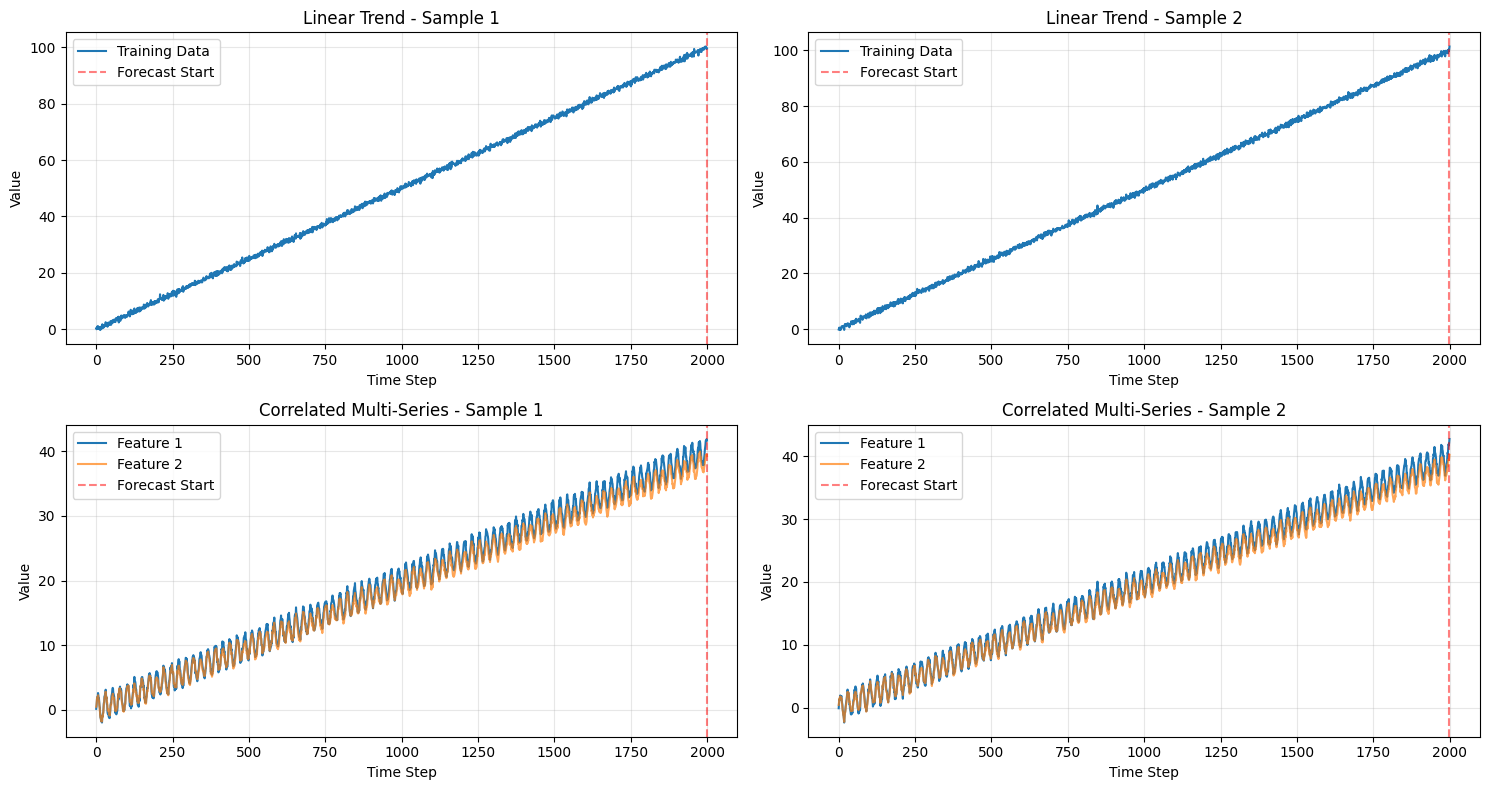

✓ Training data visualization complete


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plot linear trend samples
for i in range(2):
    axes[0, i].plot(linear_train[i, :, 0], label="Training Data", linewidth=1.5)
    axes[0, i].axvline(x=CONTEXT_LENGTH-1, color='red', linestyle='--', alpha=0.5, label='Forecast Start')
    axes[0, i].set_title(f"Linear Trend - Sample {i+1}")
    axes[0, i].set_xlabel("Time Step")
    axes[0, i].set_ylabel("Value")
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

# Plot multi-series samples
for i in range(2):
    axes[1, i].plot(multi_train[i, :, 0], label="Feature 1", linewidth=1.5)
    axes[1, i].plot(multi_train[i, :, 1], label="Feature 2", linewidth=1.5, alpha=0.7)
    axes[1, i].axvline(x=CONTEXT_LENGTH-1, color='red', linestyle='--', alpha=0.5, label='Forecast Start')
    axes[1, i].set_title(f"Correlated Multi-Series - Sample {i+1}")
    axes[1, i].set_xlabel("Time Step")
    axes[1, i].set_ylabel("Value")
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training data visualization complete")

## 5. Forecast with All Models

We'll test each model with both datasets and evaluate their performance.

In [5]:
linear_train.shape

(8, 2000, 1)

### 5.1 FlowState (Point Forecasts)

In [ ]:
print("=" * 60)
print("FLOWSTATE MODEL")
print("=" * 60)

# Linear trend dataset
print("\n1. Linear Trend Dataset (single feature)")
request_linear_fs = FlowStateForecastRequest(
    x=linear_train,
    horizon=HORIZON,
    scale_factor=1.0,
    prediction_type="mean",
    output_type="point"
)

response_linear_fs = client.forecast(request_linear_fs)
print(f"  Response shape: {response_linear_fs.point.shape}")
print(f"  Metadata: {response_linear_fs.metadata}")

# Evaluate
mse_linear_fs = mse(linear_test, response_linear_fs.point)
mase_linear_fs = mase(linear_test, response_linear_fs.point, linear_train)
print(f"  MSE: {mse_linear_fs:.4f}")
print(f"  MASE: {mase_linear_fs:.4f}")

# Multi-series dataset
print("\n2. Correlated Multi-Series Dataset (2 features)")
request_multi_fs = FlowStateForecastRequest(
    x=multi_train,
    horizon=HORIZON,
    scale_factor=1.0,
    prediction_type="mean",
    output_type="point"
)

response_multi_fs = client.forecast(request_multi_fs)
print(f"  Response shape: {response_multi_fs.point.shape}")
print(f"  Metadata: {response_multi_fs.metadata}")

# Evaluate
mse_multi_fs = mse(multi_test, response_multi_fs.point)
mase_multi_fs = mase(multi_test, response_multi_fs.point, multi_train)
print(f"  MSE: {mse_multi_fs:.4f}")
print(f"  MASE: {mase_multi_fs:.4f}")

print("\n✓ FlowState forecasts complete")

In [11]:
HORIZON

48

### 5.2 Chronos2 (Probabilistic Forecasts)

In [ ]:
print("=" * 60)
print("CHRONOS2 MODEL")
print("=" * 60)

# Quantile levels for probabilistic forecasting
QUANTILES = [0.1, 0.25, 0.5, 0.75, 0.9]

# Linear trend dataset
print("\n1. Linear Trend Dataset (single feature)")
request_linear_c2 = Chronos2ForecastRequest(
    x=linear_train,
    horizon=HORIZON,
    output_type="quantiles",
    quantiles=QUANTILES
)

response_linear_c2 = client.forecast(request_linear_c2)
print(f"  Response shape: {response_linear_c2.quantiles.shape}")
print(f"  Metadata: {response_linear_c2.metadata}")

# Evaluate point forecast (use median)
point_linear_c2 = response_linear_c2.quantiles[:, :, 2:3]  # Median (0.5 quantile), keep 3D
mse_linear_c2 = mse(linear_test, point_linear_c2)
mase_linear_c2 = mase(linear_test, point_linear_c2, linear_train)
crps_linear_c2 = crps_from_quantiles(linear_test, response_linear_c2.quantiles, QUANTILES)
print(f"  MSE (median): {mse_linear_c2:.4f}")
print(f"  MASE (median): {mase_linear_c2:.4f}")
print(f"  CRPS: {crps_linear_c2:.4f}")

# Multi-series dataset
print("\n2. Correlated Multi-Series Dataset (2 features)")
request_multi_c2 = Chronos2ForecastRequest(
    x=multi_train,
    horizon=HORIZON,
    output_type="quantiles",
    quantiles=QUANTILES
)

response_multi_c2 = client.forecast(request_multi_c2)
print(f"  Response shape: {response_multi_c2.quantiles.shape}")
print(f"  Metadata: {response_multi_c2.metadata}")

# Evaluate point forecast (use median)
point_multi_c2 = response_multi_c2.quantiles[:, :, 2:3]  # Median, keep 3D
mse_multi_c2 = mse(multi_test, point_multi_c2)
mase_multi_c2 = mase(multi_test, point_multi_c2, multi_train)
# Note: CRPS expects single feature, so we'll compute per feature
crps_multi_c2_f1 = crps_from_quantiles(multi_test[:, :, 0:1], response_multi_c2.quantiles, QUANTILES)
crps_multi_c2_f2 = crps_from_quantiles(multi_test[:, :, 1:2], response_multi_c2.quantiles, QUANTILES)
print(f"  MSE (median): {mse_multi_c2:.4f}")
print(f"  MASE (median): {mase_multi_c2:.4f}")
print(f"  CRPS (feature 1): {crps_multi_c2_f1:.4f}")
print(f"  CRPS (feature 2): {crps_multi_c2_f2:.4f}")

print("\n✓ Chronos2 forecasts complete")

In [13]:
response_linear_c2

NameError: name 'response_linear_c2' is not defined

### 5.3 TiRex (Point Forecasts)

In [ ]:
print("=" * 60)
print("TIREX MODEL")
print("=" * 60)

# Linear trend dataset
print("\n1. Linear Trend Dataset (single feature)")
request_linear_tr = TiRexForecastRequest(
    x=linear_train,
    horizon=HORIZON,
    output_type="point"
)

response_linear_tr = client.forecast(request_linear_tr)
print(f"  Response shape: {response_linear_tr.point.shape}")
print(f"  Metadata: {response_linear_tr.metadata}")

# Evaluate
mse_linear_tr = mse(linear_test, response_linear_tr.point)
mase_linear_tr = mase(linear_test, response_linear_tr.point, linear_train)
print(f"  MSE: {mse_linear_tr:.4f}")
print(f"  MASE: {mase_linear_tr:.4f}")

# Multi-series dataset
print("\n2. Correlated Multi-Series Dataset (2 features)")
request_multi_tr = TiRexForecastRequest(
    x=multi_train,
    horizon=HORIZON,
    output_type="point"
)

response_multi_tr = client.forecast(request_multi_tr)
print(f"  Response shape: {response_multi_tr.point.shape}")
print(f"  Metadata: {response_multi_tr.metadata}")

# Evaluate
mse_multi_tr = mse(multi_test, response_multi_tr.point)
mase_multi_tr = mase(multi_test, response_multi_tr.point, multi_train)
print(f"  MSE: {mse_multi_tr:.4f}")
print(f"  MASE: {mase_multi_tr:.4f}")

print("\n✓ TiRex forecasts complete")

## 6. Model Comparison Summary

In [ ]:
# Create comparison table
comparison_data = {
    "Model": ["FlowState", "Chronos2", "TiRex"],
    "Linear_MSE": [mse_linear_fs, mse_linear_c2, mse_linear_tr],
    "Linear_MASE": [mase_linear_fs, mase_linear_c2, mase_linear_tr],
    "Linear_CRPS": ["-", crps_linear_c2, "-"],
    "Multi_MSE": [mse_multi_fs, mse_multi_c2, mse_multi_tr],
    "Multi_MASE": [mase_multi_fs, mase_multi_c2, mase_multi_tr],
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print("\nLinear Trend Dataset (Single Feature):")
print(comparison_df[["Model", "Linear_MSE", "Linear_MASE", "Linear_CRPS"]].to_string(index=False))

print("\n\nCorrelated Multi-Series Dataset (2 Features):")
print(comparison_df[["Model", "Multi_MSE", "Multi_MASE"]].to_string(index=False))

# Identify best models
print("\n\n" + "=" * 80)
print("BEST MODELS BY METRIC")
print("=" * 80)

# Linear dataset
best_linear_mse_idx = np.argmin([mse_linear_fs, mse_linear_c2, mse_linear_tr])
best_linear_mase_idx = np.argmin([mase_linear_fs, mase_linear_c2, mase_linear_tr])
models = ["FlowState", "Chronos2", "TiRex"]

print("\nLinear Trend Dataset:")
print(f"  Best MSE: {models[best_linear_mse_idx]} ({[mse_linear_fs, mse_linear_c2, mse_linear_tr][best_linear_mse_idx]:.4f})")
print(f"  Best MASE: {models[best_linear_mase_idx]} ({[mase_linear_fs, mase_linear_c2, mase_linear_tr][best_linear_mase_idx]:.4f})")

# Multi-series dataset
best_multi_mse_idx = np.argmin([mse_multi_fs, mse_multi_c2, mse_multi_tr])
best_multi_mase_idx = np.argmin([mase_multi_fs, mase_multi_c2, mase_multi_tr])

print("\nCorrelated Multi-Series Dataset:")
print(f"  Best MSE: {models[best_multi_mse_idx]} ({[mse_multi_fs, mse_multi_c2, mse_multi_tr][best_multi_mse_idx]:.4f})")
print(f"  Best MASE: {models[best_multi_mase_idx]} ({[mase_multi_fs, mase_multi_c2, mase_multi_tr][best_multi_mase_idx]:.4f})")

print("\n" + "=" * 80)

## 7. Visualize Forecasts - Linear Trend Dataset

In [ ]:
# Pick a sample to visualize (index 0)
sample_idx = 0

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# FlowState
axes[0].plot(np.arange(CONTEXT_LENGTH), linear_train[sample_idx, :, 0], 
             label="Training Data", color="blue", linewidth=2)
axes[0].plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), linear_test[sample_idx, :, 0], 
             label="Ground Truth", color="green", linewidth=2, linestyle="--")
axes[0].plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), response_linear_fs.point[sample_idx, :, 0], 
             label="FlowState Forecast", color="red", linewidth=2, marker="o", markersize=3)
axes[0].axvline(x=CONTEXT_LENGTH, color="gray", linestyle=":", alpha=0.5)
axes[0].set_title(f"FlowState - Linear Trend Forecast (MSE: {mse_linear_fs:.4f}, MASE: {mase_linear_fs:.4f})", fontweight="bold")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Value")
axes[0].legend(loc="best")
axes[0].grid(True, alpha=0.3)

# Chronos2 (with uncertainty bands)
axes[1].plot(np.arange(CONTEXT_LENGTH), linear_train[sample_idx, :, 0], 
             label="Training Data", color="blue", linewidth=2)
axes[1].plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), linear_test[sample_idx, :, 0], 
             label="Ground Truth", color="green", linewidth=2, linestyle="--")
axes[1].plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), response_linear_c2.quantiles[sample_idx, :, 2], 
             label="Chronos2 Median", color="red", linewidth=2, marker="o", markersize=3)
# Add uncertainty bands
axes[1].fill_between(
    np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON),
    response_linear_c2.quantiles[sample_idx, :, 0],  # 10th percentile
    response_linear_c2.quantiles[sample_idx, :, 4],  # 90th percentile
    alpha=0.2, color="red", label="10th-90th Percentile"
)
axes[1].axvline(x=CONTEXT_LENGTH, color="gray", linestyle=":", alpha=0.5)
axes[1].set_title(f"Chronos2 - Probabilistic Forecast (MSE: {mse_linear_c2:.4f}, MASE: {mase_linear_c2:.4f}, CRPS: {crps_linear_c2:.4f})", fontweight="bold")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Value")
axes[1].legend(loc="best")
axes[1].grid(True, alpha=0.3)

# TiRex
axes[2].plot(np.arange(CONTEXT_LENGTH), linear_train[sample_idx, :, 0], 
             label="Training Data", color="blue", linewidth=2)
axes[2].plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), linear_test[sample_idx, :, 0], 
             label="Ground Truth", color="green", linewidth=2, linestyle="--")
axes[2].plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), response_linear_tr.point[sample_idx, :, 0], 
             label="TiRex Forecast", color="red", linewidth=2, marker="o", markersize=3)
axes[2].axvline(x=CONTEXT_LENGTH, color="gray", linestyle=":", alpha=0.5)
axes[2].set_title(f"TiRex - Linear Trend Forecast (MSE: {mse_linear_tr:.4f}, MASE: {mase_linear_tr:.4f})", fontweight="bold")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("Value")
axes[2].legend(loc="best")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Linear trend visualization complete")

## 8. Visualize Forecasts - Multi-Series Dataset

In [ ]:
# Pick a sample to visualize (index 0)
sample_idx = 0

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# FlowState - Feature 1 and 2
for feat_idx in range(2):
    ax = axes[0, feat_idx]
    ax.plot(np.arange(CONTEXT_LENGTH), multi_train[sample_idx, :, feat_idx], 
            label="Training Data", color="blue", linewidth=2)
    ax.plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), multi_test[sample_idx, :, feat_idx], 
            label="Ground Truth", color="green", linewidth=2, linestyle="--")
    ax.plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), response_multi_fs.point[sample_idx, :, feat_idx], 
            label="FlowState Forecast", color="red", linewidth=2, marker="o", markersize=3)
    ax.axvline(x=CONTEXT_LENGTH, color="gray", linestyle=":", alpha=0.5)
    ax.set_title(f"FlowState - Feature {feat_idx+1}", fontweight="bold")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

# Chronos2 - Feature 1 and 2
for feat_idx in range(2):
    ax = axes[1, feat_idx]
    ax.plot(np.arange(CONTEXT_LENGTH), multi_train[sample_idx, :, feat_idx], 
            label="Training Data", color="blue", linewidth=2)
    ax.plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), multi_test[sample_idx, :, feat_idx], 
            label="Ground Truth", color="green", linewidth=2, linestyle="--")
    ax.plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), response_multi_c2.quantiles[sample_idx, :, 2], 
            label="Chronos2 Median", color="red", linewidth=2, marker="o", markersize=3)
    # Add uncertainty bands
    ax.fill_between(
        np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON),
        response_multi_c2.quantiles[sample_idx, :, 0],
        response_multi_c2.quantiles[sample_idx, :, 4],
        alpha=0.2, color="red", label="10th-90th Percentile"
    )
    ax.axvline(x=CONTEXT_LENGTH, color="gray", linestyle=":", alpha=0.5)
    ax.set_title(f"Chronos2 - Feature {feat_idx+1}", fontweight="bold")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

# TiRex - Feature 1 and 2
for feat_idx in range(2):
    ax = axes[2, feat_idx]
    ax.plot(np.arange(CONTEXT_LENGTH), multi_train[sample_idx, :, feat_idx], 
            label="Training Data", color="blue", linewidth=2)
    ax.plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), multi_test[sample_idx, :, feat_idx], 
            label="Ground Truth", color="green", linewidth=2, linestyle="--")
    ax.plot(np.arange(CONTEXT_LENGTH, CONTEXT_LENGTH + HORIZON), response_multi_tr.point[sample_idx, :, feat_idx], 
            label="TiRex Forecast", color="red", linewidth=2, marker="o", markersize=3)
    ax.axvline(x=CONTEXT_LENGTH, color="gray", linestyle=":", alpha=0.5)
    ax.set_title(f"TiRex - Feature {feat_idx+1}", fontweight="bold")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Multi-series visualization complete")

## 9. Per-Sample Error Analysis

In [ ]:
# Calculate per-sample errors for linear dataset
mse_per_sample_fs = mse(linear_test, response_linear_fs.point, reduction='none')
mse_per_sample_c2 = mse(linear_test, point_linear_c2, reduction='none')
mse_per_sample_tr = mse(linear_test, response_linear_tr.point, reduction='none')

# Visualize per-sample errors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
x = np.arange(BATCH_SIZE)
width = 0.25
axes[0].bar(x - width, mse_per_sample_fs, width, label='FlowState', alpha=0.8)
axes[0].bar(x, mse_per_sample_c2, width, label='Chronos2', alpha=0.8)
axes[0].bar(x + width, mse_per_sample_tr, width, label='TiRex', alpha=0.8)
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('MSE')
axes[0].set_title('Per-Sample MSE Comparison (Linear Trend)', fontweight='bold')
axes[0].set_xticks(x)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot
axes[1].boxplot([mse_per_sample_fs, mse_per_sample_c2, mse_per_sample_tr],
                labels=['FlowState', 'Chronos2', 'TiRex'])
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE Distribution Across Samples', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nPer-Sample Statistics (Linear Trend):")
print(f"FlowState   - Mean: {mse_per_sample_fs.mean():.4f}, Std: {mse_per_sample_fs.std():.4f}, Min: {mse_per_sample_fs.min():.4f}, Max: {mse_per_sample_fs.max():.4f}")
print(f"Chronos2    - Mean: {mse_per_sample_c2.mean():.4f}, Std: {mse_per_sample_c2.std():.4f}, Min: {mse_per_sample_c2.min():.4f}, Max: {mse_per_sample_c2.max():.4f}")
print(f"TiRex       - Mean: {mse_per_sample_tr.mean():.4f}, Std: {mse_per_sample_tr.std():.4f}, Min: {mse_per_sample_tr.min():.4f}, Max: {mse_per_sample_tr.max():.4f}")

print("\n✓ Per-sample error analysis complete")

## 10. Key Insights and Conclusions

In [ ]:
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print("\n1. Model Performance:")
print("   - All models successfully handled both single and multi-feature datasets")
print(f"   - Best overall for linear trend: {models[best_linear_mse_idx]}")
print(f"   - Best overall for multi-series: {models[best_multi_mse_idx]}")

print("\n2. Probabilistic Forecasting:")
print(f"   - Chronos2 provided uncertainty quantification with CRPS: {crps_linear_c2:.4f}")
print("   - Uncertainty bands captured ground truth well in most samples")

print("\n3. Metrics Comparison:")
print("   - MSE: Measures average squared error (sensitive to outliers)")
print("   - MASE: Scale-independent, compares to naive baseline")
print("   - CRPS: Evaluates probabilistic forecast quality")

print("\n4. Recommendations:")
print("   - Use FlowState for: Fast point forecasts with known patterns")
print("   - Use Chronos2 for: Uncertainty quantification and probabilistic forecasts")
print("   - Use TiRex for: Efficient transformer-based forecasting")

print("\n" + "="*80)
print("✓ Model comparison complete!")
print("="*80)